# **Deep Q-Learning para Lunar Lander**

Este notebook incluye una implementacion del algoritmo Deep Q-learning (DQN) para el problema del Lunar lander (ver [Lunar Lander documentación](https://gymnasium.farama.org/environments/box2d/lunar_lander/)).

El problema del Lunar Lander simula el aterrizaje de un módulo lunar. El objetivo es que la nave descienda suavemente a la superficie, minimizando el consumo de combustible, mientras se contrarresta la gravedad.  Es un desafío clásico de control óptimo.

##Librerias

In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"
!pip install imageio-ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 30.5 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376478 sha256=9d8ee146e4f4fd2d9686567005d442d400e0da4acf40ee2c8f4ac690a1c026c9
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 61.2 MB/s eta 0:00:00


In [ ]:
#!pip install gymnasium[classic-control]

import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random
import math
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import cv2
import warnings

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Hiperparámetros

In [ ]:
# Learning rate
LEARNING_RATE = 0.001
# Batch size
BATCH_SIZE = 64
# Discount factor gamma
GAMMA = 0.99
# Size of the replay memory (replay buffer) that saves transitions
MEMORY_SIZE = 100000
# Values related to the exploration rate used by the epsilon-greedy policy
EXPLORATION_RATE_MAX = 1
EXPLORATION_RATE_MIN = 0.01
EXPLORATION_RATE_DECAY = 0.96
# Maximum number of episodes for training
MAX_EPISODES_FOR_TRAINING = 600
# Goal score to be achieved during the training process
TRAINING_GOAL = 200
# Number of episodes used to check the goal score during the training process
EPISODES_TO_CHECK_TRAINING_GOAL = 15
# Number of episodes used to evaluate the model performance after training
EPISODES_TO_EVALUATE_MODEL_PERFORMANCE = 30

## Clase ReplayMemory

Memoria de las transiciones para la repetición de la experiencia.

In [ ]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]
        terminal_states = self.terminal_states[batch]
        return states, actions, rewards, states_next, terminal_states

Funcion para la visualización del aterrizaje.

In [ ]:
# Funcion para la visualización del aterrizaje
def show_video(episode):
    mp4list = glob.glob(f'videos{episode}.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("No se pudo encontrar el video")


## Clase DQN

Agente de aprendizaje por refuerzo con una Deep Q-Network.

In [ ]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create neural model
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)

        # Neural model
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Dense(128, input_shape=(number_of_observations,), \
                             activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(128, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(128, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(number_of_actions, activation="linear"))
        self.model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state, exploration_rate):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model(state).numpy()
            return np.argmax(q_values[0])

    def select_greedy_policy(self, state):
        # Generate an action for a given state using greedy policy
        state = np.reshape(state, [1, self.number_of_observations])
        q_values = self.model(state).numpy()
        return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model(states).numpy()
        q_next_states = self.model(next_states).numpy()

        for i in range(BATCH_SIZE):
             if (terminal_states[i]):
                  q_targets[i][actions[i]] = rewards[i]
             else:
                  q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])

        self.model.train_on_batch(states, q_targets)

    def add_score(self, score):
        # Add the obtained score to a list to be presented later
        self.scores.append(score)

    def delete_scores(self):
        # Delete the scores
        self.scores = []

    def average_score(self, number_of_episodes):
        # Compute average score of the last episodes
        index = len(agent.scores) - number_of_episodes
        return np.mean(self.scores[max(0,index):(len(agent.scores))])

    def display_scores_graphically(self):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")

## Entorno Lunar Lander

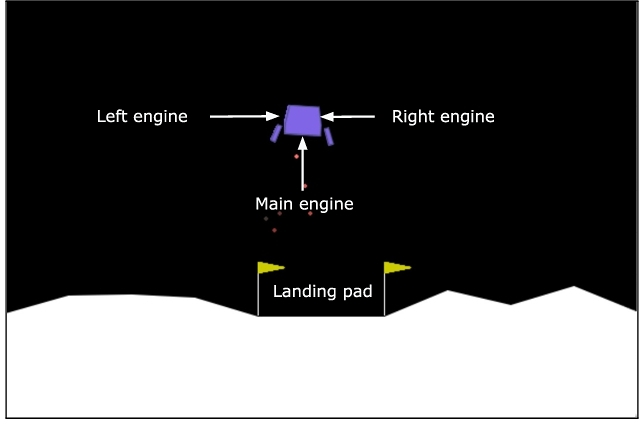

Vector de estado:

El estado es un vector de 8 dimensiones: las coordenadas del módulo de aterrizaje en x e y, sus velocidades lineales en x e y, su ángulo, su velocidad angular y dos 1  booleanos que representan si cada pata está en contacto con el suelo o no.

Acciones:
- 0: no hacer nada
- 1: encender el motor izquierdo
- 2: encender el motor principal
- 3: encender el motor derecho

In [ ]:
def create_environment():
    # Create simulated environment
    environment = gym.make("LunarLander-v3", render_mode='rgb_array')
    seed = 42
    environment.reset(seed=seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

## Programa de entrenamiento




Para dar mayor estabilidad al entrenamiento se emplea un planificador para la tasa de aprendizaje, que comienza con una tasa base de 0.001 y la reduce en 0.0001 cada 5000 transiciones. Con la misma finalidad se ha modificado la función de pérdida a lo largo del entrenamiento. El entrenamiento comienza empleando como función de pérdida el MSE, pero a partir de las 25000 transiciones, se sustituye por la función de pérdida de Huber, que es menos sensible a la presencia de instancias atípicas cuyo error tenga una gran magnitud.

Episode   1: score -390 (exploration rate: 1.000, average score: -390, transitions: 99)
Episode   2: score -164 (exploration rate: 0.960, average score: -278, transitions: 183)
Episode   3: score -113 (exploration rate: 0.922, average score: -223, transitions: 300)
Episode   4: score -120 (exploration rate: 0.885, average score: -197, transitions: 389)
Episode   5: score -287 (exploration rate: 0.849, average score: -215, transitions: 472)
Episode   6: score -72 (exploration rate: 0.815, average score: -192, transitions: 553)
Episode   7: score -136 (exploration rate: 0.783, average score: -184, transitions: 681)
Episode   8: score -95 (exploration rate: 0.751, average score: -173, transitions: 786)
Episode   9: score -252 (exploration rate: 0.721, average score: -182, transitions: 893)
Episode  10: score -31 (exploration rate: 0.693, average score: -167, transitions: 1011)
Episode  11: score -261 (exploration rate: 0.665, average score: -175, transitions: 1113)
Episode  12: score -184

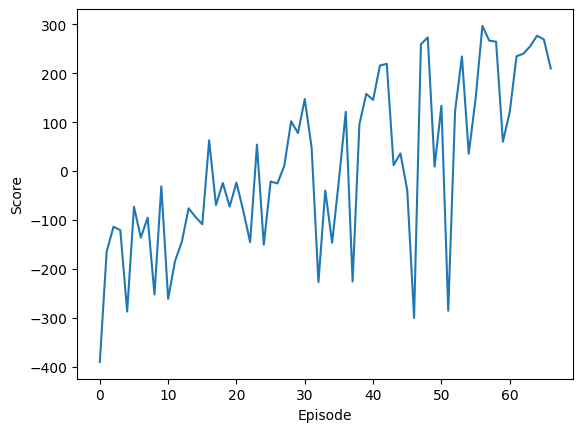

In [ ]:
environment, number_of_observations, number_of_actions = create_environment()
agent = DQN(number_of_observations, number_of_actions)
episode = 0
start_time = time.perf_counter()
total_steps = 1
exploration_rate = EXPLORATION_RATE_MAX
goal_reached = False
bajar_lr = 5000
lr = 0.001
cadencia = 10
max_frames = 1800
num_videos = 0
while (episode < MAX_EPISODES_FOR_TRAINING) and not(goal_reached):
    episode += 1
    if bajar_lr <= agent.memory.current_size:
        bajar_lr+=5000
        lr-=0.0001
        if lr <= 0.0005:
            print("learning rate="+ str(lr)+ " Perdida: Huber")
            agent.model.compile(loss="Huber", optimizer=keras.optimizers.Adam(learning_rate=lr))
        else:
            print("learning rate="+ str(lr)+ " Perdida: mse")
            agent.model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=lr))
    score = 0
    state, info = environment.reset()
    end_episode = False
    frames = []
    frame_count = 0
    while not(end_episode):
        if episode % cadencia == 0 and frame_count < max_frames:
            frame = environment.render()
            frame_resized = cv2.resize(frame, (608, 400), interpolation=cv2.INTER_LANCZOS4)
            frames.append(frame_resized)
            frame_count += 1
        # Select an action for the current state
        action = agent.select(state, exploration_rate)

        # Execute the action on the environment
        state_next, reward, terminal_state, truncated, info = environment.step(action)

        # Store in memory the transition (s,a,r,s')
        agent.remember(state, action, reward, state_next, terminal_state)

        score += reward

        # Learn using a batch of experience stored in memory
        agent.learn()

        # Detect end of episode
        if terminal_state or truncated:
            end_episode = True
            agent.add_score(score)
            average_score = agent.average_score(EPISODES_TO_CHECK_TRAINING_GOAL)
            if average_score >= TRAINING_GOAL: goal_reached = True
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} ".format(math.trunc(score)), end = '')
            print("(exploration rate: %.3f, " % exploration_rate, end = '')
            print("average score: {0:>3}, ".format(round(average_score)), end = '')
            print("transitions: " + str(agent.memory.current_size) + ")")
            if episode % cadencia == 0:
                num_videos += 1
                imageio.mimsave(f'videos{episode}.mp4', frames, fps=30)
        else:
            state = state_next
            total_steps += 1

    # Decrease exploration rate
    exploration_rate *= EXPLORATION_RATE_DECAY
    exploration_rate = max(EXPLORATION_RATE_MIN, exploration_rate)

print("Time for training:", round((time.perf_counter() - start_time)/60), "minutes")
print("Score (average last episodes):", round(average_score))
print("Score (max):", round(max(agent.scores)))

agent.display_scores_graphically()

## Aprendiendo a aterrizar, una mirada visual al entrenamiento

Se ha incluido una visualización del comportamiento del agente cada 10 episodios de entrenamiento, así como en el último episodio de test. Esta renderización hace que el entrenamiento tarde aproximadamente un minuto más.

In [ ]:
print("Aprendiendo a aterrizar, una mirada visual al entrenamiento:")
for i in range(num_videos):
    print("\nEpisodio", (i+1)*cadencia, ":")
    show_video((i+1)*cadencia)

Aprendiendo a aterrizar, una mirada visual al entrenamiento:

Episodio 10 :



Episodio 20 :



Episodio 30 :



Episodio 40 :



Episodio 50 :



Episodio 60 :



## Test final



In [ ]:
agent.delete_scores()
episode = 0
start_time = time.perf_counter()
while (episode < EPISODES_TO_EVALUATE_MODEL_PERFORMANCE):
    episode += 1
    score = 0
    state, info = environment.reset()
    end_episode = False
    frames = []
    frame_count = 0
    while not(end_episode):
        if episode == EPISODES_TO_EVALUATE_MODEL_PERFORMANCE and frame_count < max_frames:
            frame = environment.render()
            frame_resized = cv2.resize(frame, (608, 400), interpolation=cv2.INTER_LANCZOS4)
            frames.append(frame_resized)
            frame_count += 1

        # Select an action for the current state
        action = agent.select_greedy_policy(state)

        # Execute the action in the environment
        state_next, reward, terminal_state, truncated, info = environment.step(action)

        score += reward

        # Detect end of episode and print
        if terminal_state or truncated:
            agent.add_score(score)
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} \n".format(round(score)), end = '')
            end_episode = True
        else:
            state = state_next

print("Time for testing:", round((time.perf_counter() - start_time)/60), "minutes")
print("Score (average):", round(np.mean(agent.scores)))
print("Score (max):", round(max(agent.scores)))
print("\nVisualizacion del aterrizaje:")
imageio.mimsave('videos0.mp4', frames, fps=30)
show_video(0)

Episode   1: score 266 
Episode   2: score 308 
Episode   3: score 264 
Episode   4: score 194 
Episode   5: score 306 
Episode   6: score 261 
Episode   7: score 312 
Episode   8: score 220 
Episode   9: score 277 
Episode  10: score 249 
Episode  11: score 251 
Episode  12: score 234 
Episode  13: score  96 
Episode  14: score 241 
Episode  15: score 254 
Episode  16: score 164 
Episode  17: score 306 
Episode  18: score  99 
Episode  19: score 278 
Episode  20: score 225 
Episode  21: score 281 
Episode  22: score 257 
Episode  23: score 248 
Episode  24: score 237 
Episode  25: score 253 
Episode  26: score 298 
Episode  27: score 269 
Episode  28: score 268 
Episode  29: score 139 
Episode  30: score 272 
Time for testing: 1 minutes
Score (average): 244
Score (max): 312

Visualizacion del aterrizaje:
